In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [3]:
df = pd.read_excel("data/eBay (active buyers).xlsx")
df['Cum. Accounts'] = df['Cum. Accounts'].astype(float)
data = df['Cum. Accounts'].dropna().values
t = np.arange(len(data))


BASS MODEL.

In [6]:
def bass_model(params, t, N0):
    p, q, M = params
    N = np.zeros_like(t, dtype=float)
    N[0] = N0
    for i in range(1, len(t)):
        N[i] = N[i-1] + (p + q * (N[i-1]/M)) * (M - N[i-1])
    return N

In [10]:
def objective(params, t, data):
    N_pred = bass_model(params, t, data[0])
    return np.sum((data - N_pred)**2)

p_init, q_init, M_init = 0.01, 0.3, max(data)*1.2
params_init = [p_init, q_init, M_init]
bounds = [(0,1), (0,1), (max(data), max(data)*10)]

result = minimize(objective, params_init, args=(t, data), bounds=bounds)
p_est, q_est, M_est = result.x

print(f"Estimated p: {p_est:.4f}")
print(f"Estimated q: {q_est:.4f}")
print(f"Estimated M: {M_est:.2f} million")

Estimated p: 0.0398
Estimated q: 0.0000
Estimated M: 189.02 million


FITTING.

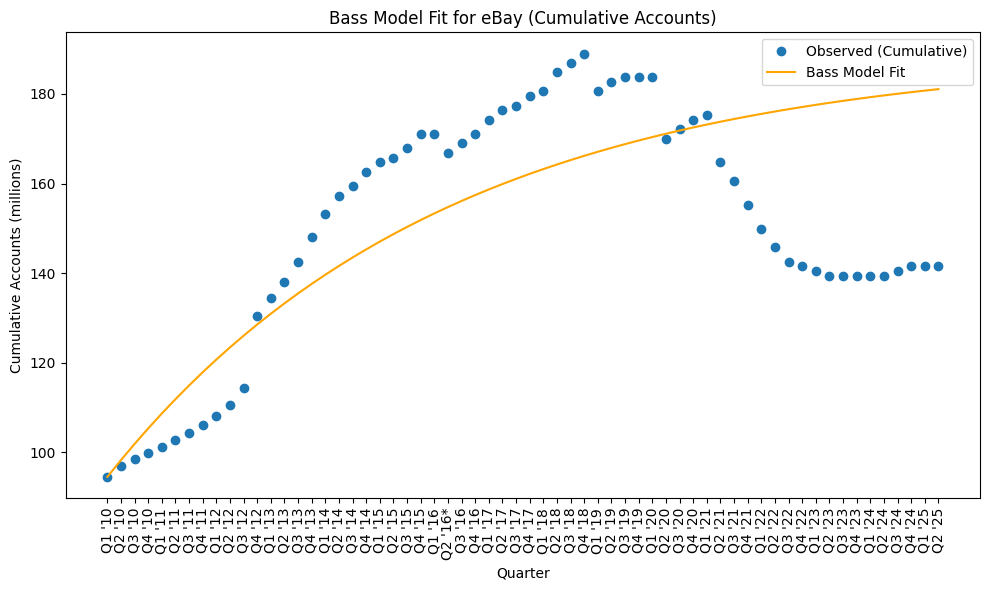

In [11]:
N_pred = bass_model([p_est, q_est, M_est], t, data[0])

plt.figure(figsize=(10,6))
plt.plot(df['Quarter'][:len(data)], data, 'o', label='Observed (Cumulative)')
plt.plot(df['Quarter'][:len(data)], N_pred, '-', color='orange', label='Bass Model Fit')
plt.xticks(rotation=90)
plt.xlabel('Quarter')
plt.ylabel('Cumulative Accounts (millions)')
plt.title('Bass Model Fit for eBay (Cumulative Accounts)')
plt.legend()
plt.tight_layout()
plt.show()

BASS FORECAST. (USA FOCUS)

In [12]:
def bass_forecast(p, q, M, N0, periods):
    N = [N0]
    for t in range(1, periods):
        N_next = N[-1] + (p + q * N[-1]/M) * (M - N[-1])
        N.append(N_next)
    return np.array(N)

M_thredup = 50
N0 = 0.1
periods = 20

N_forecast = bass_forecast(p_est, q_est, M_thredup, N0, periods)
S_forecast = np.diff(N_forecast, prepend=N0)

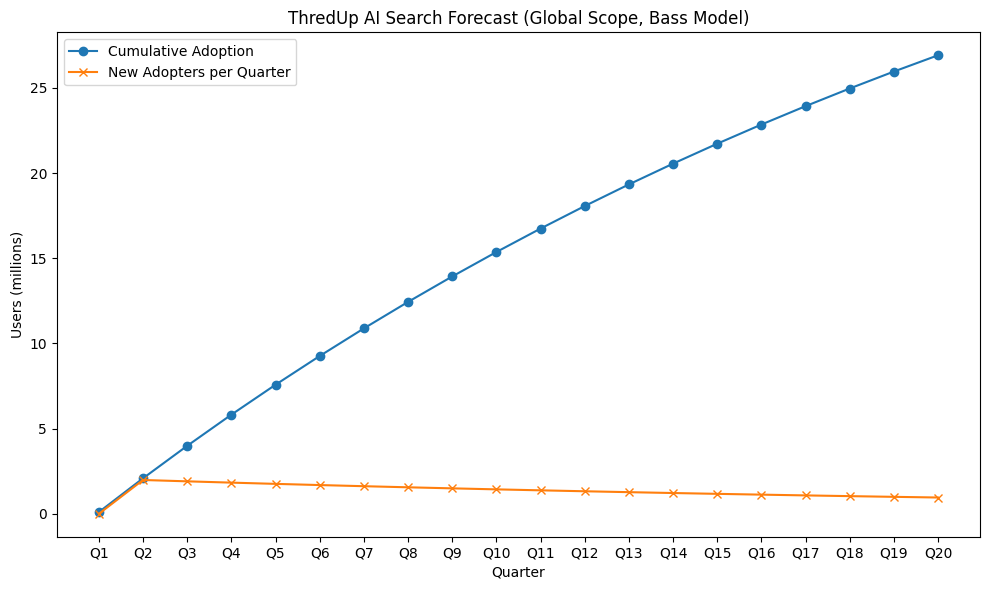

In [13]:
quarters = [f"Q{i+1}" for i in range(periods)]
plt.figure(figsize=(10,6))
plt.plot(quarters, N_forecast, "o-", label="Cumulative Adoption")
plt.plot(quarters, S_forecast, "x-", label="New Adopters per Quarter")
plt.title("ThredUp AI Search Forecast (Global Scope, Bass Model)")
plt.xlabel("Quarter"); plt.ylabel("Users (millions)")
plt.legend(); plt.tight_layout(); plt.show()

In [15]:
forecast_df = pd.DataFrame({
    "Quarter": quarters,
    "Cumulative_Adopters_M": np.round(N_forecast, 2),
    "New_Adopters_M": np.round(S_forecast, 2)})

forecast_df.head(10)


# forecast_df.to_excel("ThredUp_Forecast_Table.xlsx", index=False)
# files.download("ThredUp_Forecast_Table.xlsx")


,Quarter,Cumulative_Adopters_M,New_Adopters_M
0,Q1,0.10,0.00
1,Q2,2.08,1.98
2,Q3,3.99,1.91
3,Q4,5.82,1.83
4,Q5,7.58,1.76
5,Q6,9.26,1.69
6,Q7,10.88,1.62
7,Q8,12.44,1.56
8,Q9,13.93,1.49
9,Q10,15.36,1.43


OPTIONAL (FURTHER RESEARCH).

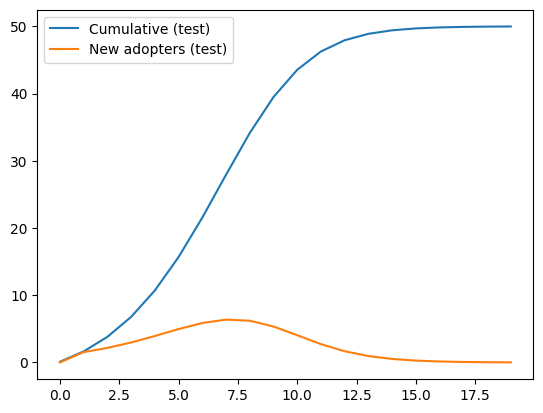

In [16]:
p_test, q_test = 0.03, 0.45
M_test = 50
N_test = bass_forecast(p_test, q_test, M_test, N0=0.1, periods=20)
S_test = np.diff(N_test, prepend=0.1)

plt.plot(N_test, label="Cumulative (test)")
plt.plot(S_test, label="New adopters (test)")
plt.legend(); plt.show()